In [ ]:
from google.colab import drive
import numpy as np
import seaborn as sns
import tensorflow as tf
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import torch.nn.functional as F

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#데이터 불러오기
path_dir=("/content/drive/MyDrive/인공지능 실습/IMS_인공지능스터디/DataSet/Dataset")

# 파일 조회
all_files = os.listdir(path_dir)

In [ ]:
#이미지 전처리
def preprocess_image(path_dir):
  images=[]
  labels=[]

  all_files = os.listdir(path_dir)

  for filename in all_files:
    if filename.endswith((".jpg", ".png")):
      img_path=os.path.join(path_dir, filename)
      try:
        img=Image.open(img_path)
        img = img.convert('RGB')  # 이미지를 RGB로 변환
        img=img.resize((224, 224)) #224*224
        transform = transforms.Compose([
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomVerticalFlip(),
                    transforms.RandomRotation(30),
                    transforms.ToTensor(),  # 이미지를 텐서로 변환
                    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 이미지 정규화
                ])
        img = transform(img)
        images.append(img)

        if 'o' in filename:
          labels.append(0) # o는 0
        elif 'x' in filename:
          labels.append(1) # x는 1
      except PIL.UnidentifiedImageError:
        print(f"failed to load image: {filename}")


  images = torch.stack(images)  # 이미지 리스트를 텐서로 변환
  labels = torch.tensor(labels)  # 레이블 리스트를 텐서로 변환

  return images, labels

images, labels= preprocess_image(path_dir)
print('Images shape:', images.size())
print('Labels shape:', labels.size())

#원핫인코딩
one_hot_encoder = OneHotEncoder()
X=[['o'],['x']]
print('\n데이터 항목X=', X)
one_hot_encoder.fit(X)
categories = one_hot_encoder.categories_
print('Categories:', categories)

print('\n모든 범주와 원핫 인코딩을 출력.')
for category in one_hot_encoder.categories_[0]:
 print(category,': \t', one_hot_encoder.transform([[category]]).toarray())

Images shape: torch.Size([280, 3, 224, 224])
Labels shape: torch.Size([280])

데이터 항목X= [['o'], ['x']]
Categories: [array(['o', 'x'], dtype=object)]

모든 범주와 원핫 인코딩을 출력.
o : 	 [[1. 0.]]
x : 	 [[0. 1.]]


In [ ]:
#training-data 랑 test-data로 나누기
def split_dataset(images, labels, train_ratio=0.7, val_ratio=0.15):
 dataset= TensorDataset(images, labels)
 train_size = int(train_ratio * len(dataset))
 val_size = int(val_ratio * len(dataset))
 test_size = len(dataset) - train_size - val_size
 train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
 return train_dataset,val_dataset, test_dataset

#train, test, val 사이즈 확인
train_dataset,val_dataset, test_dataset = split_dataset(images, labels)
print('Train dataset size:', len(train_dataset))
print('Val dataset size:', len(val_dataset))
print('Test dataset size:', len(test_dataset))

#모델에 데이터 전달(데이터 로더)
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Train dataset size: 196
Val dataset size: 42
Test dataset size: 42


In [ ]:
#cnn 모델 정의
# conv - pooling - fully conneted layer(linear) - relu

class CNN(nn.Module):
    def __init__(self):
      super(CNN, self).__init__()
     #RGB이므로 3채널, out채널은 합성곱 필터의 출력 채널 수
      self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
      self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
      self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
      self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)#최대 풀링(이미지 인식 분야)
      #입력 특성의 수와 출력 특성의 수 정의
      self.fc1 = nn.Linear(128 * 28 * 28, 512)
      self.fc2 = nn.Linear(512, 2)
      self.relu1 = nn.ReLU()
      self.bn1 = nn.BatchNorm2d(32)
      self.bn2 = nn.BatchNorm2d(64)
      self.bn3 = nn.BatchNorm2d(128)
      self.dropout = nn.Dropout(p=0.5)

#순전파 연산 - 차례대로 변수 계산하고 저장
    def forward(self, x):
      x=self.maxpool(torch.relu(self.conv1(x)))
      x=self.maxpool(torch.relu(self.conv2(x)))
      x=self.maxpool(torch.relu(self.conv3(x)))
      x = x.view(-1, 128 * 28 * 28) # 텐서를 1차원으로 변환
      x = torch.relu(self.fc1(x)) #fc1 계산 후 저장
      x=self.fc2(x)
      return x

def create_model(): # create_model 함수는 이제 CNN 클래스의 인스턴스를 반환
  return CNN()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model().to(device)

#모델 초기화
model = create_model().to(device)
model = CNN().to(device)

Epoch 1/20,Train Loss: 0.6928, Train Accuracy: 48.98%, Val Loss: 0.6910, Val Accuracy: 52.38%
Epoch 2/20,Train Loss: 0.6977, Train Accuracy: 50.00%, Val Loss: 0.6824, Val Accuracy: 64.29%
Epoch 3/20,Train Loss: 0.6727, Train Accuracy: 53.57%, Val Loss: 0.6857, Val Accuracy: 47.62%
Epoch 4/20,Train Loss: 0.6650, Train Accuracy: 55.61%, Val Loss: 0.6550, Val Accuracy: 73.81%
Epoch 5/20,Train Loss: 0.6336, Train Accuracy: 74.49%, Val Loss: 0.6167, Val Accuracy: 69.05%
Epoch 6/20,Train Loss: 0.5393, Train Accuracy: 77.04%, Val Loss: 0.5566, Val Accuracy: 73.81%
Epoch 7/20,Train Loss: 0.4405, Train Accuracy: 78.06%, Val Loss: 0.6513, Val Accuracy: 78.57%
Epoch 8/20,Train Loss: 0.4725, Train Accuracy: 75.51%, Val Loss: 0.5127, Val Accuracy: 80.95%
Epoch 9/20,Train Loss: 0.3778, Train Accuracy: 83.16%, Val Loss: 0.5586, Val Accuracy: 78.57%
Epoch 10/20,Train Loss: 0.4548, Train Accuracy: 80.10%, Val Loss: 0.6261, Val Accuracy: 59.52%
Epoch 11/20,Train Loss: 0.6412, Train Accuracy: 62.76%, Val

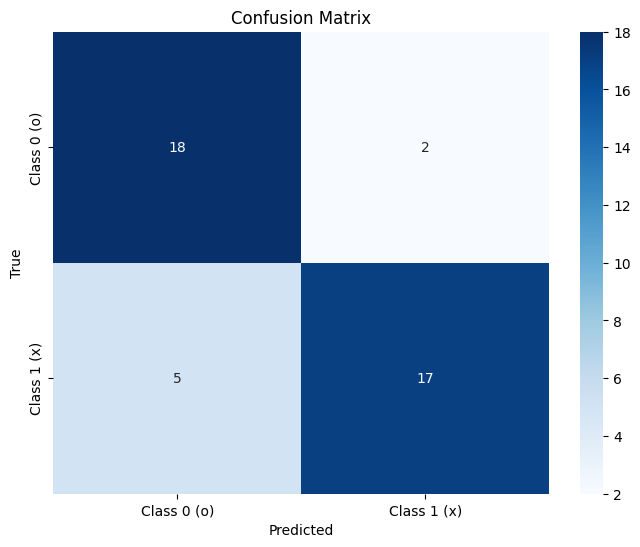

83.33333333333333

In [ ]:
#모델 훈련
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
  train_losses = []
  val_losses = []
  train_accuracies = []
  val_accuracies = []

  for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct=0
    total=0

    for inputs, labels in train_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      labels_one_hot = F.one_hot(labels, num_classes=2).float() #label을 원핫 인코딩으로 바꾸기
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels_one_hot)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      _, predicted = torch.max(outputs.data, 1) #최대값과 최대값의 인덱스 반환

      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

      #정확도
    model.eval()
    val_loss=0
    correct=0
    total=0
    with torch.no_grad():
        for inputs, labels in val_loader:
          inputs = inputs.to(device)
          labels = labels.to(device)
          labels_one_hot = F.one_hot(labels.long(), num_classes=2).float() #label 원핫인코딩으로 바꾸기
          outputs = model(inputs)
          loss = criterion(outputs, labels_one_hot)
          val_loss += loss.item()
          _, predicted = torch.max(outputs.data, 1)

          total += labels.size(0)
          correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs},"
          f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.2f}%, "
            f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

#모델 저장
torch.save(model.state_dict(), "CNN_ox_classify.pt")

#모델 불러오기
model=CNN().to(device)
if os.path.exists("CNN_ox_classify.pt"):
    model.load_state_dict(torch.load("CNN_ox_classify.pt"))
else:
    print("Error: Model file 'CNN_ox_classify.pt' not found.")

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

#모델 평가
def evaluate_model(model, test_loader, criterion):
  model.eval()
  correct = 0
  total = 0
  y_true = []
  y_pred = []

  with torch.no_grad(): #평가시 기울기 계산 안함
    for inputs, labels in test_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      labels_one_hot = F.one_hot(labels.long(), num_classes=2).float() #label 원핫인코딩으로 바꾸기
      outputs = model(inputs)
      _, predicted = torch.max(outputs.data, 1)

      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      y_true.extend(labels.cpu().numpy())
      y_pred.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy}%")
    print(classification_report(y_true, y_pred, target_names=['Class 0 (o)', 'Class 1 (x)']))

    # Confusion Matrix 시각화
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0 (o)', 'Class 1 (x)'], yticklabels=['Class 0 (o)', 'Class 1 (x)'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return accuracy

#모델 훈련 , 평가
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20)
evaluate_model(model, test_loader, criterion)

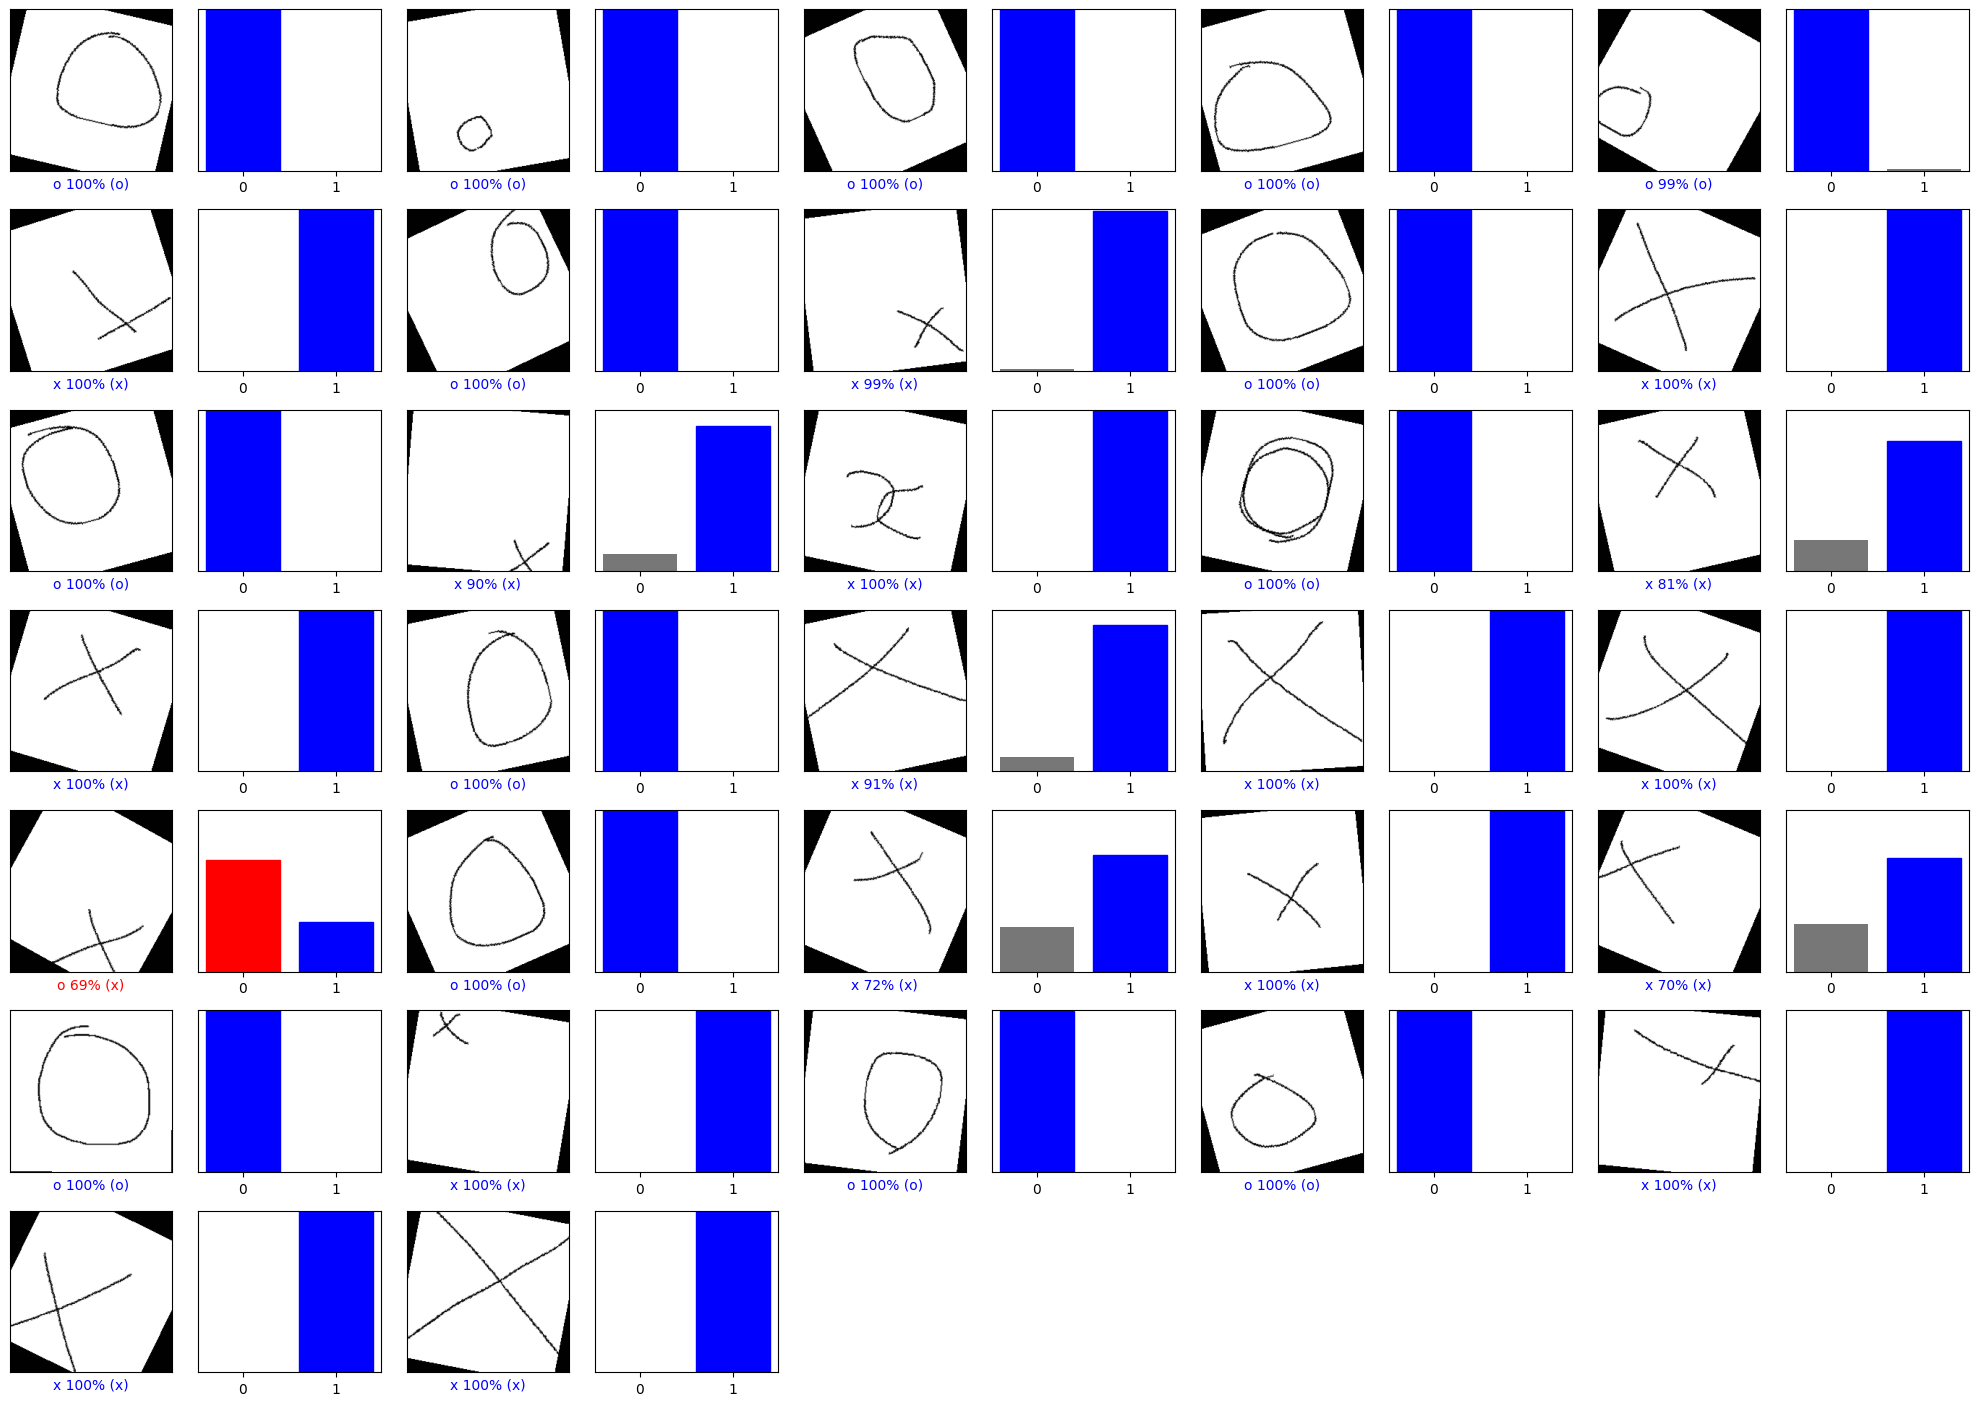

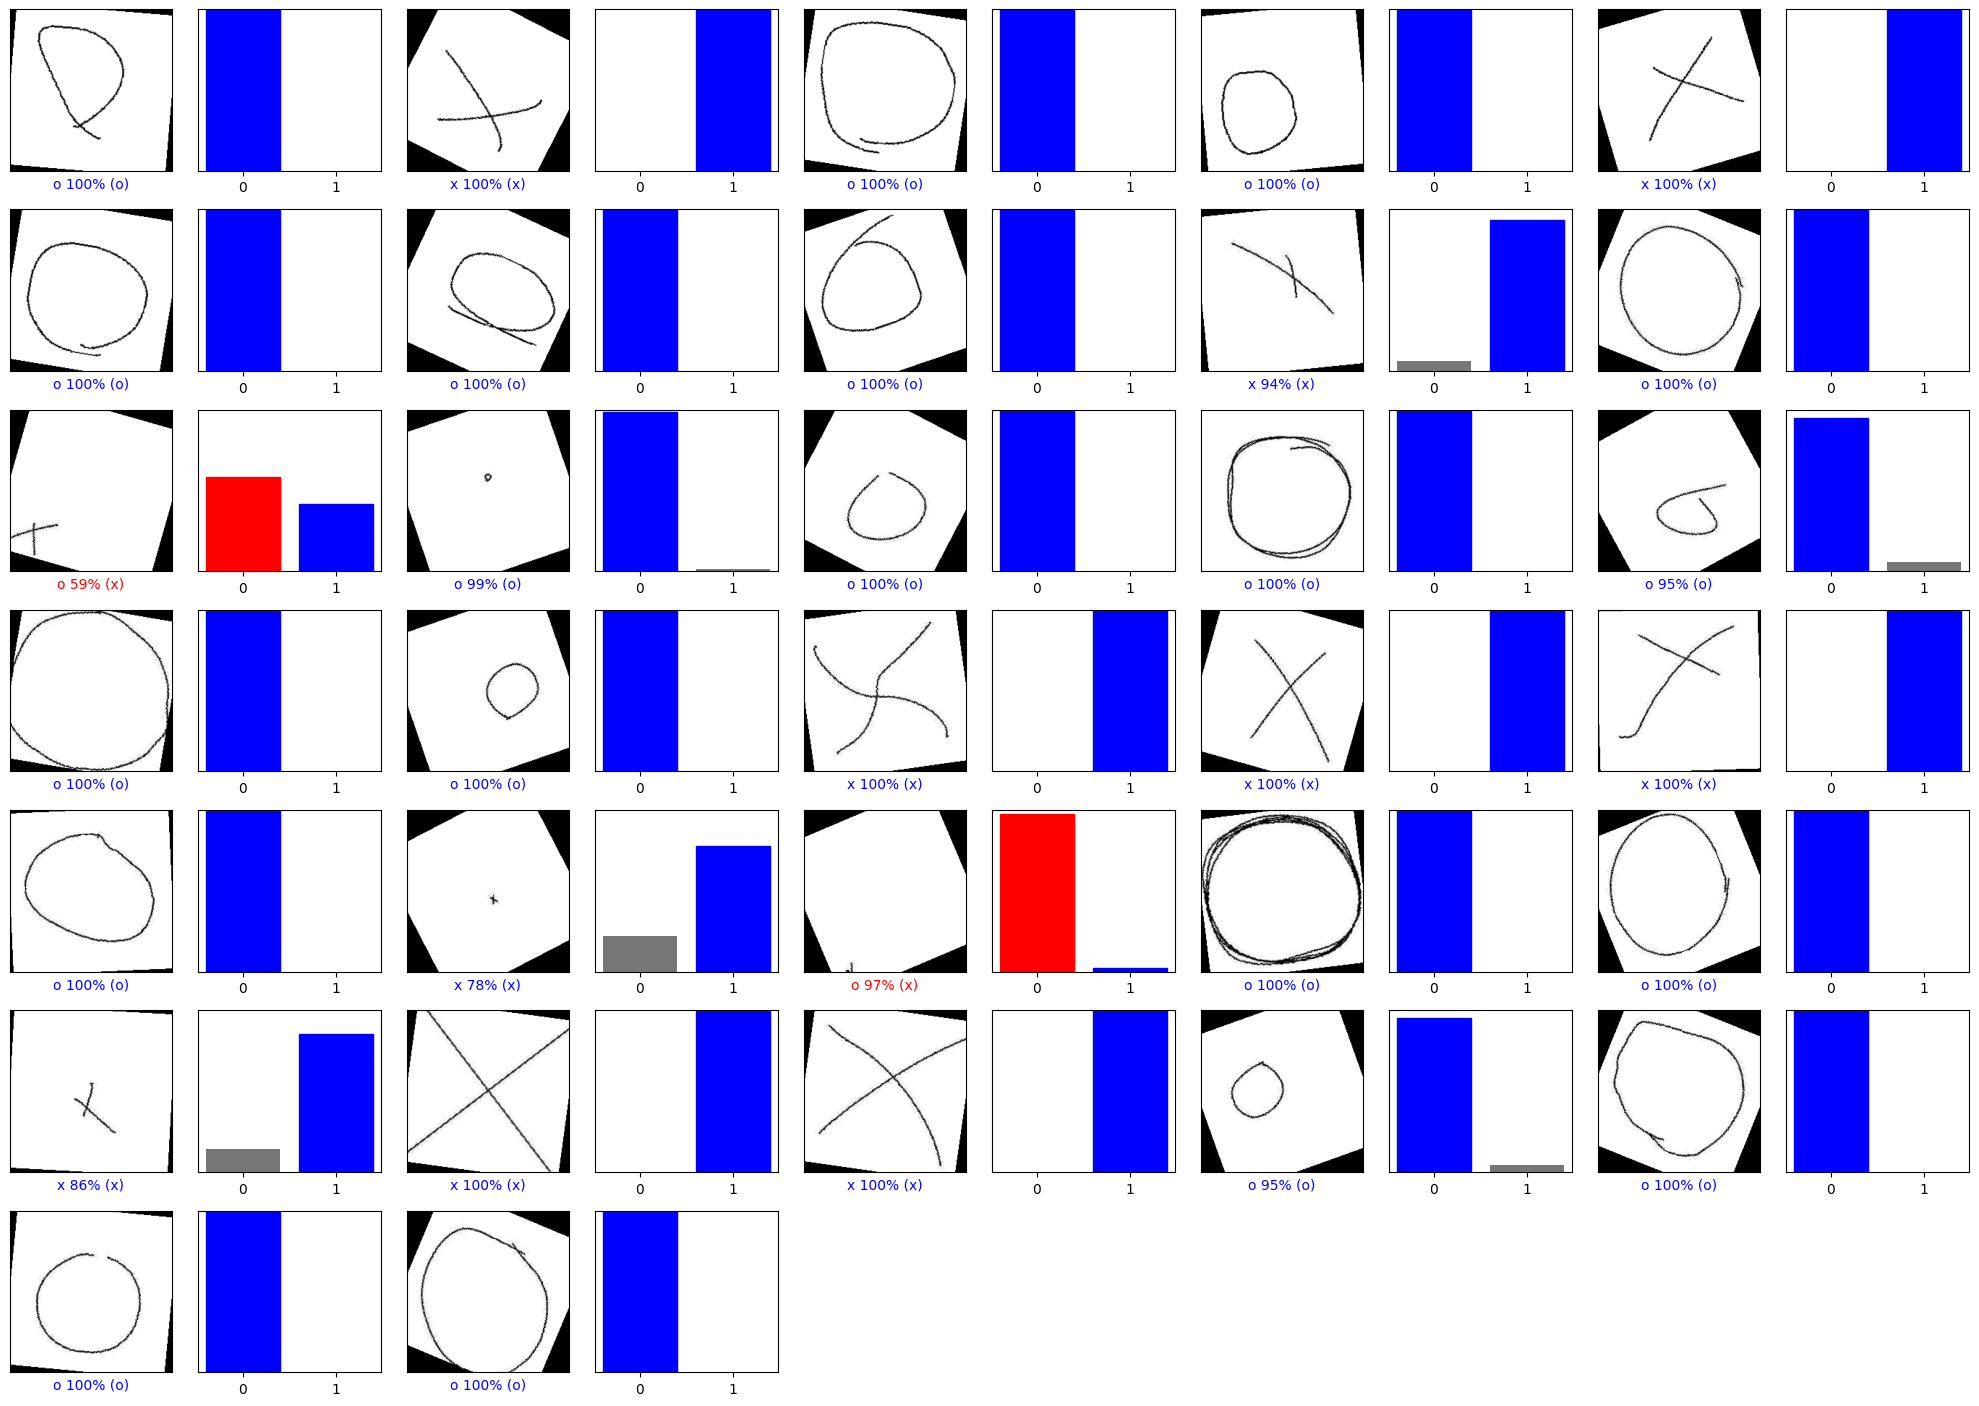

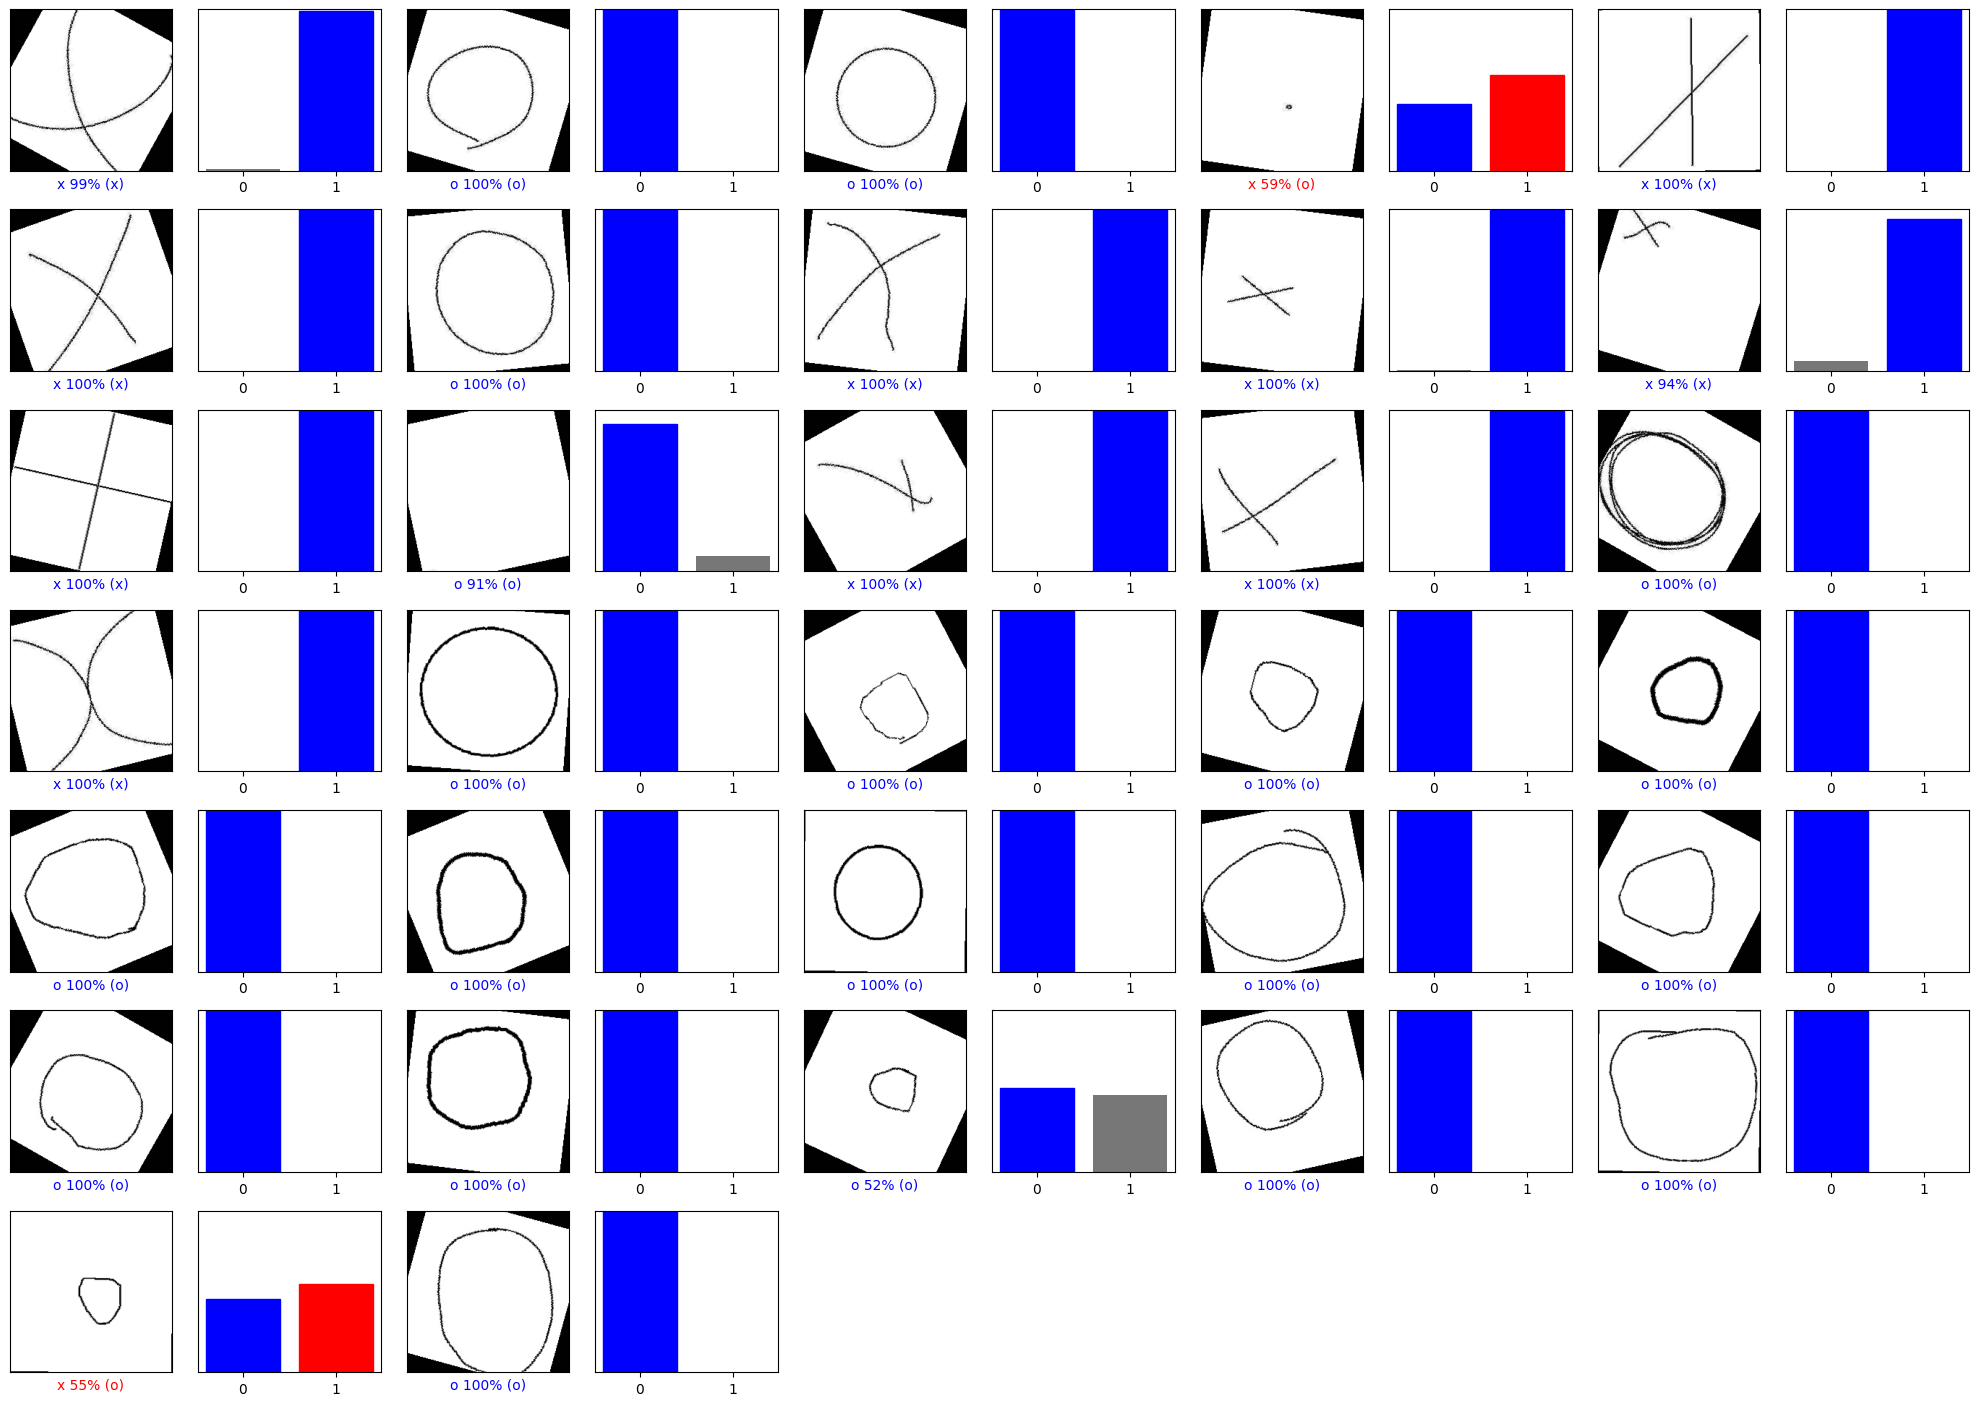

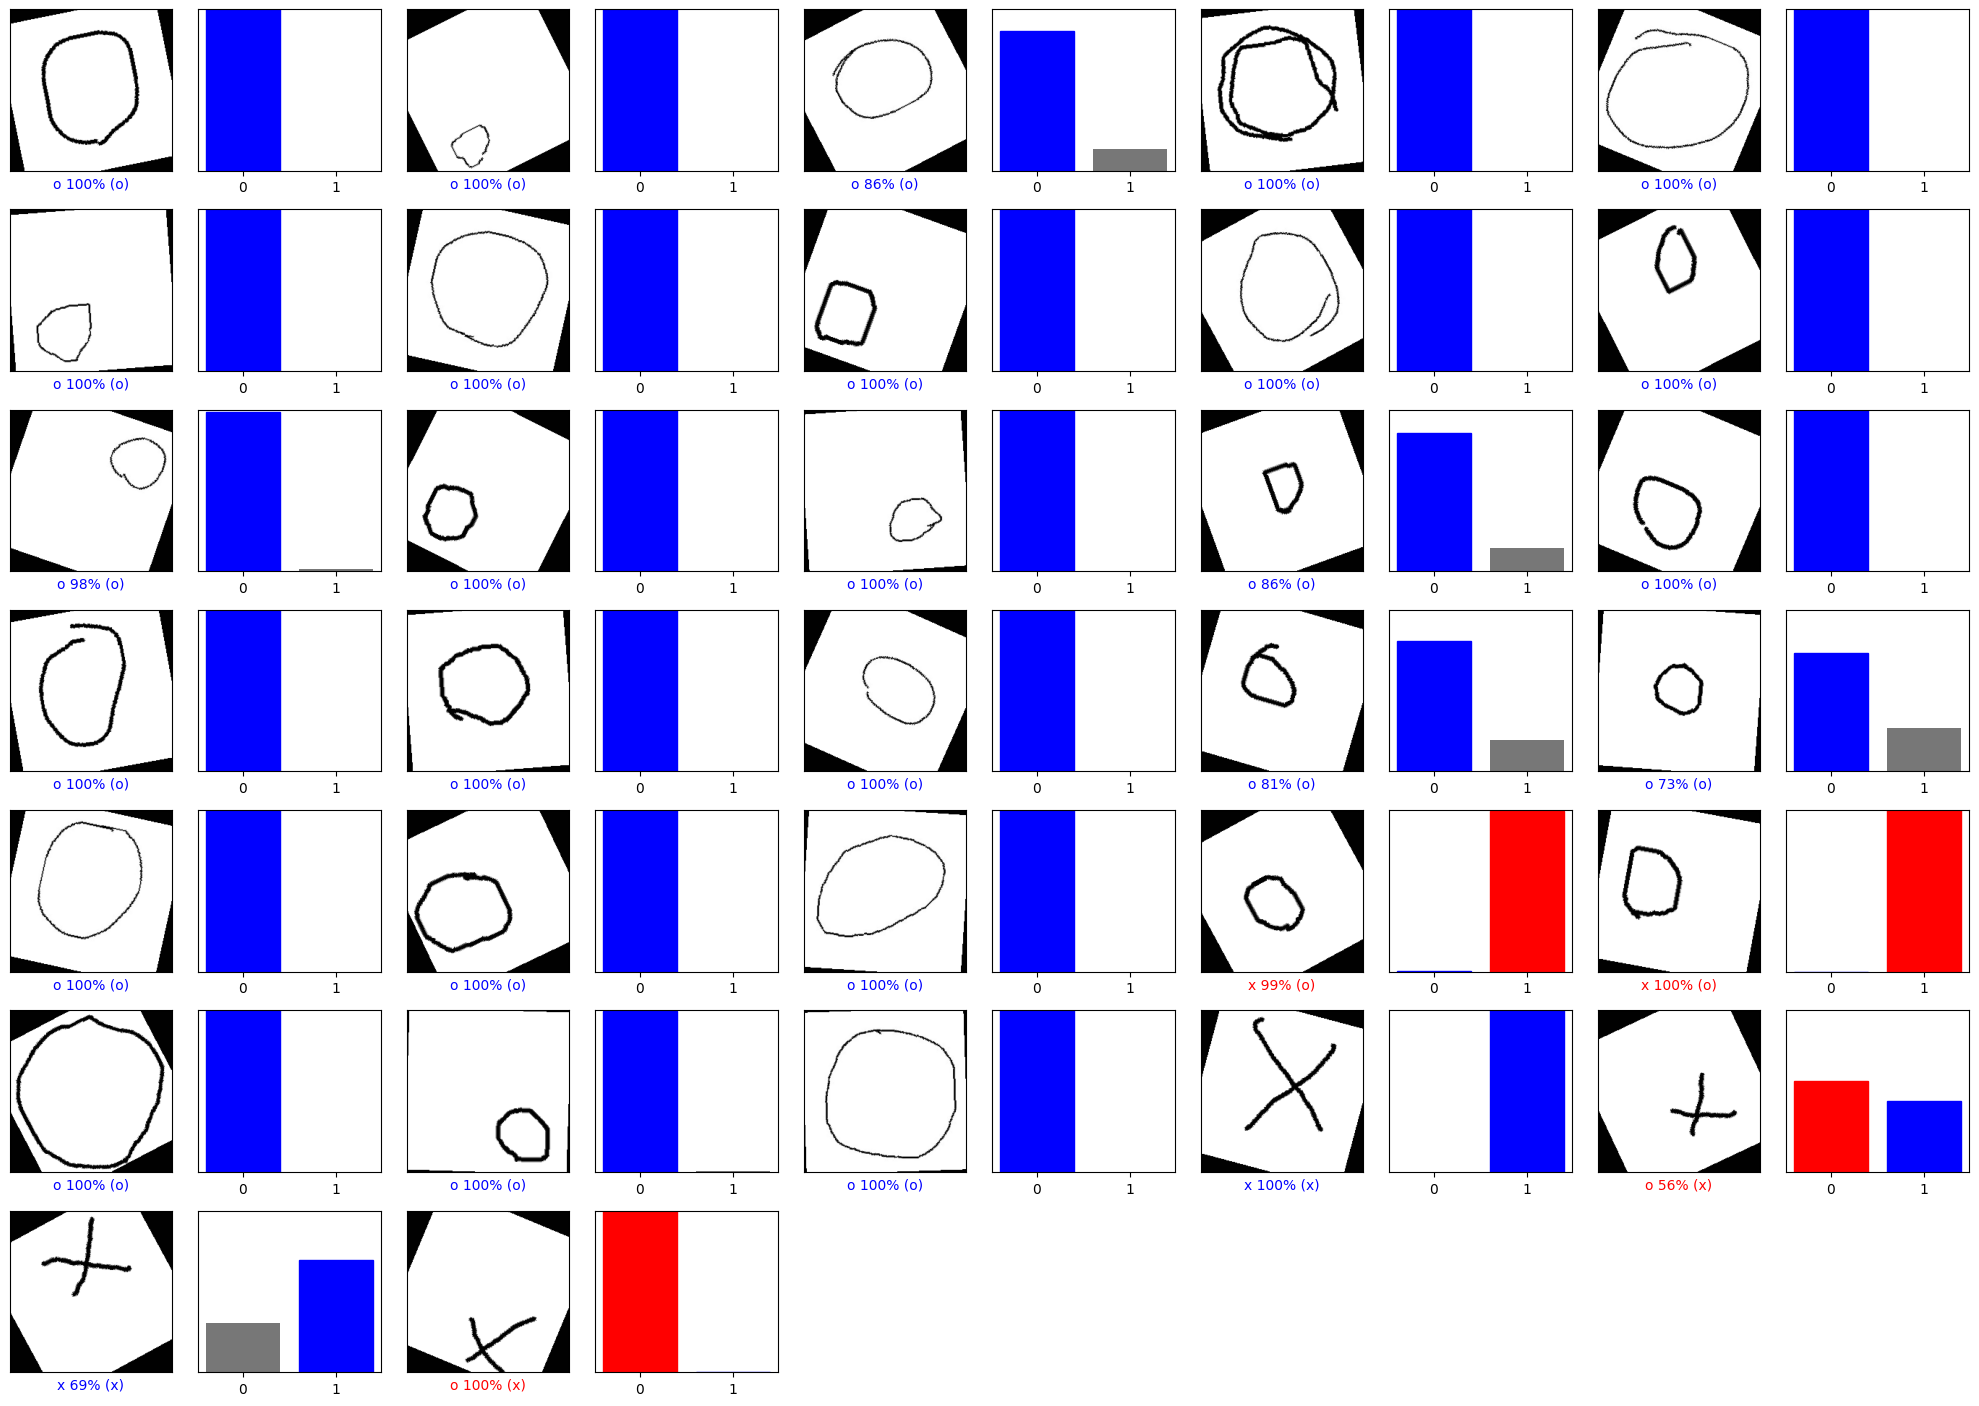

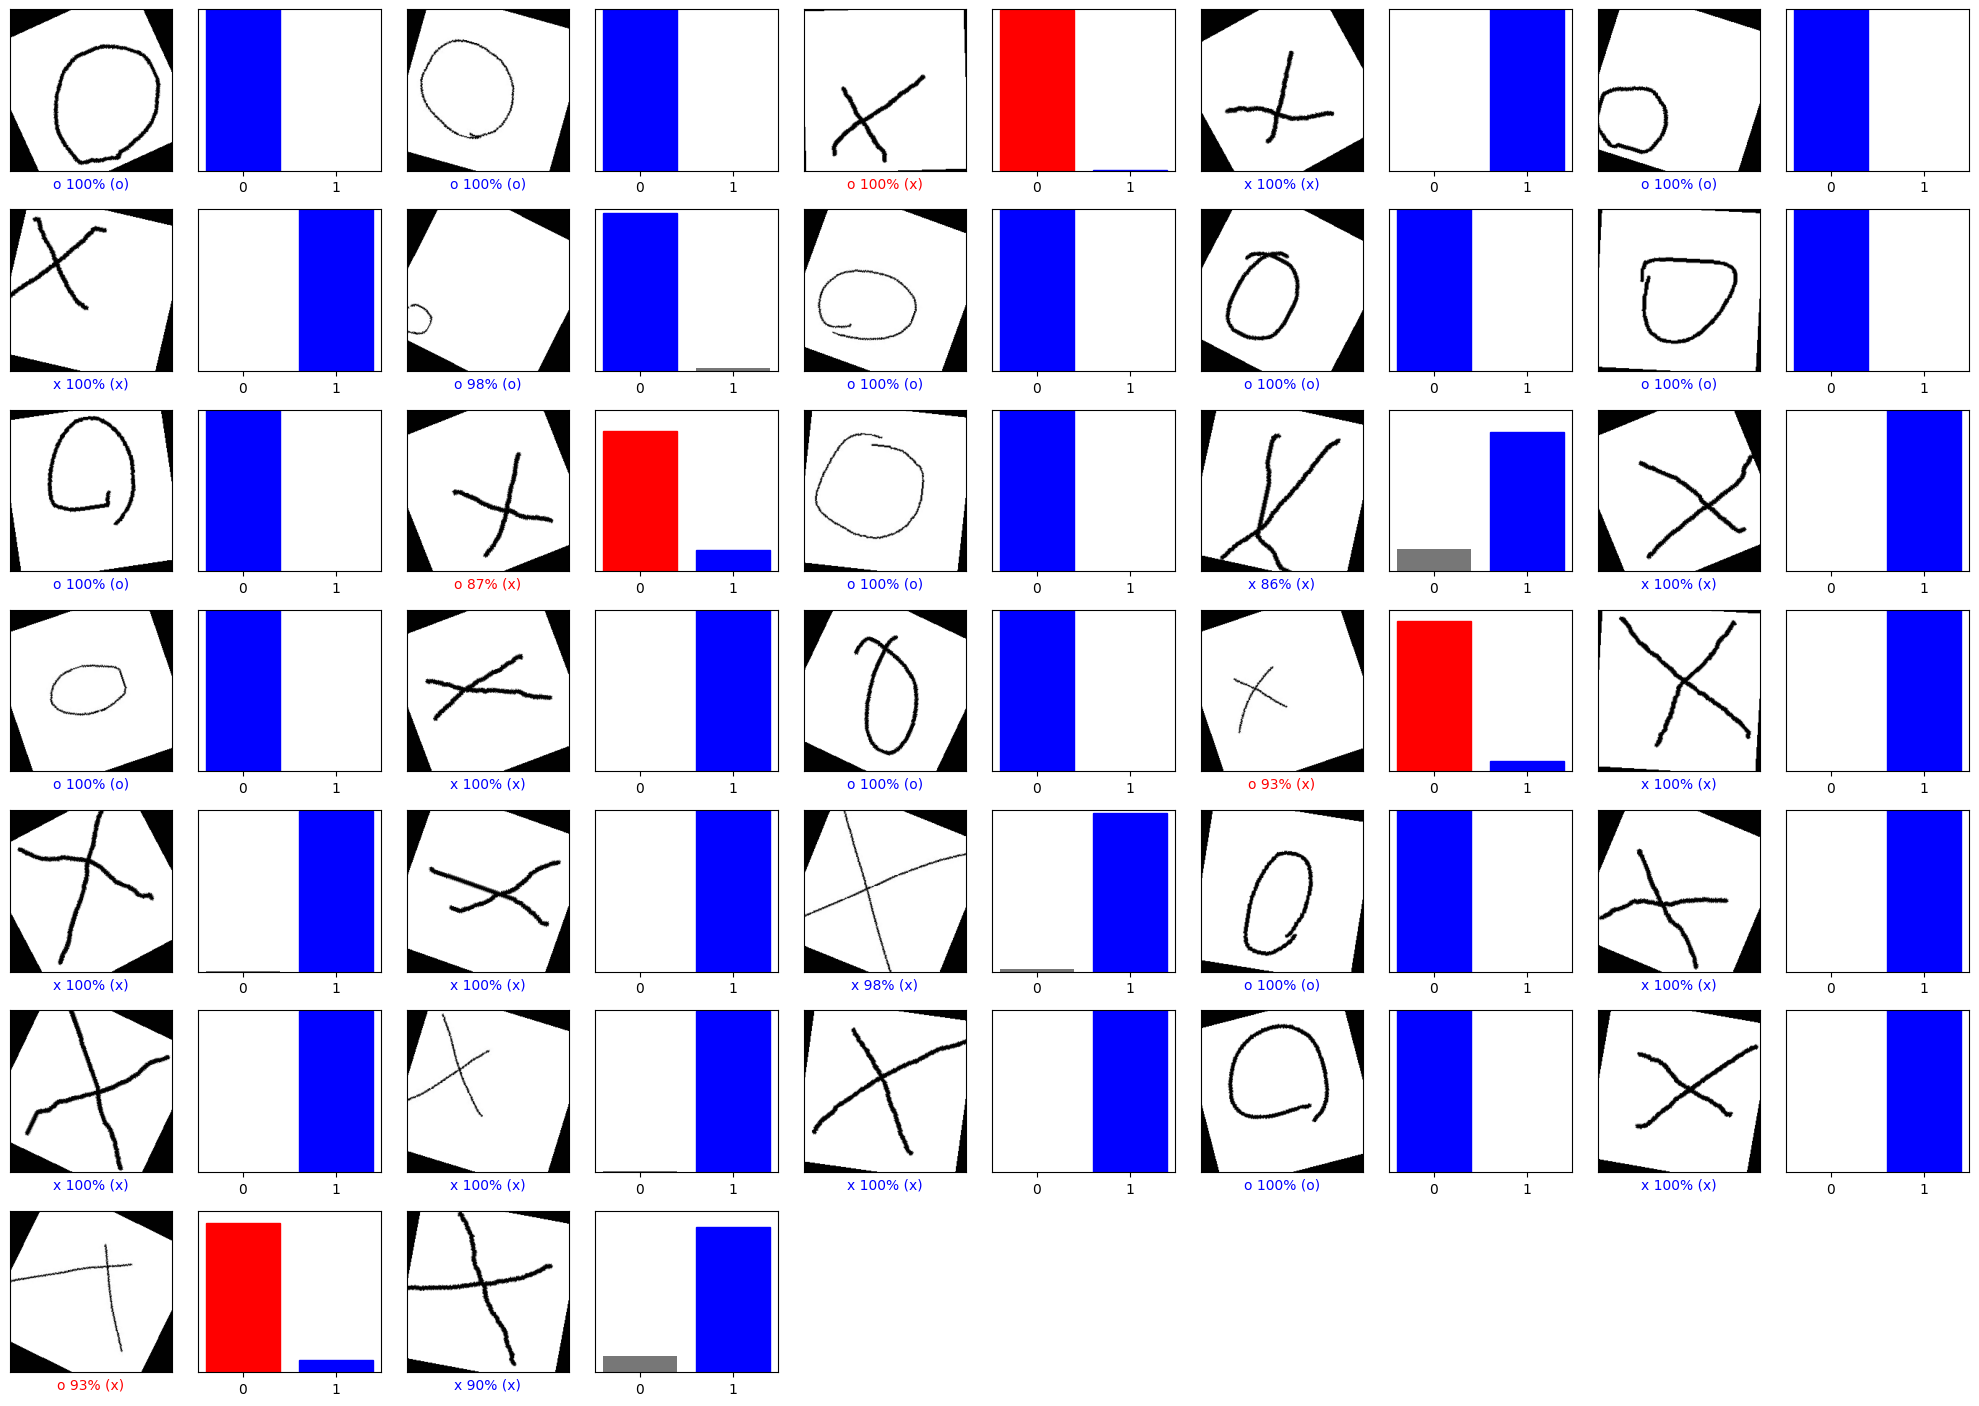

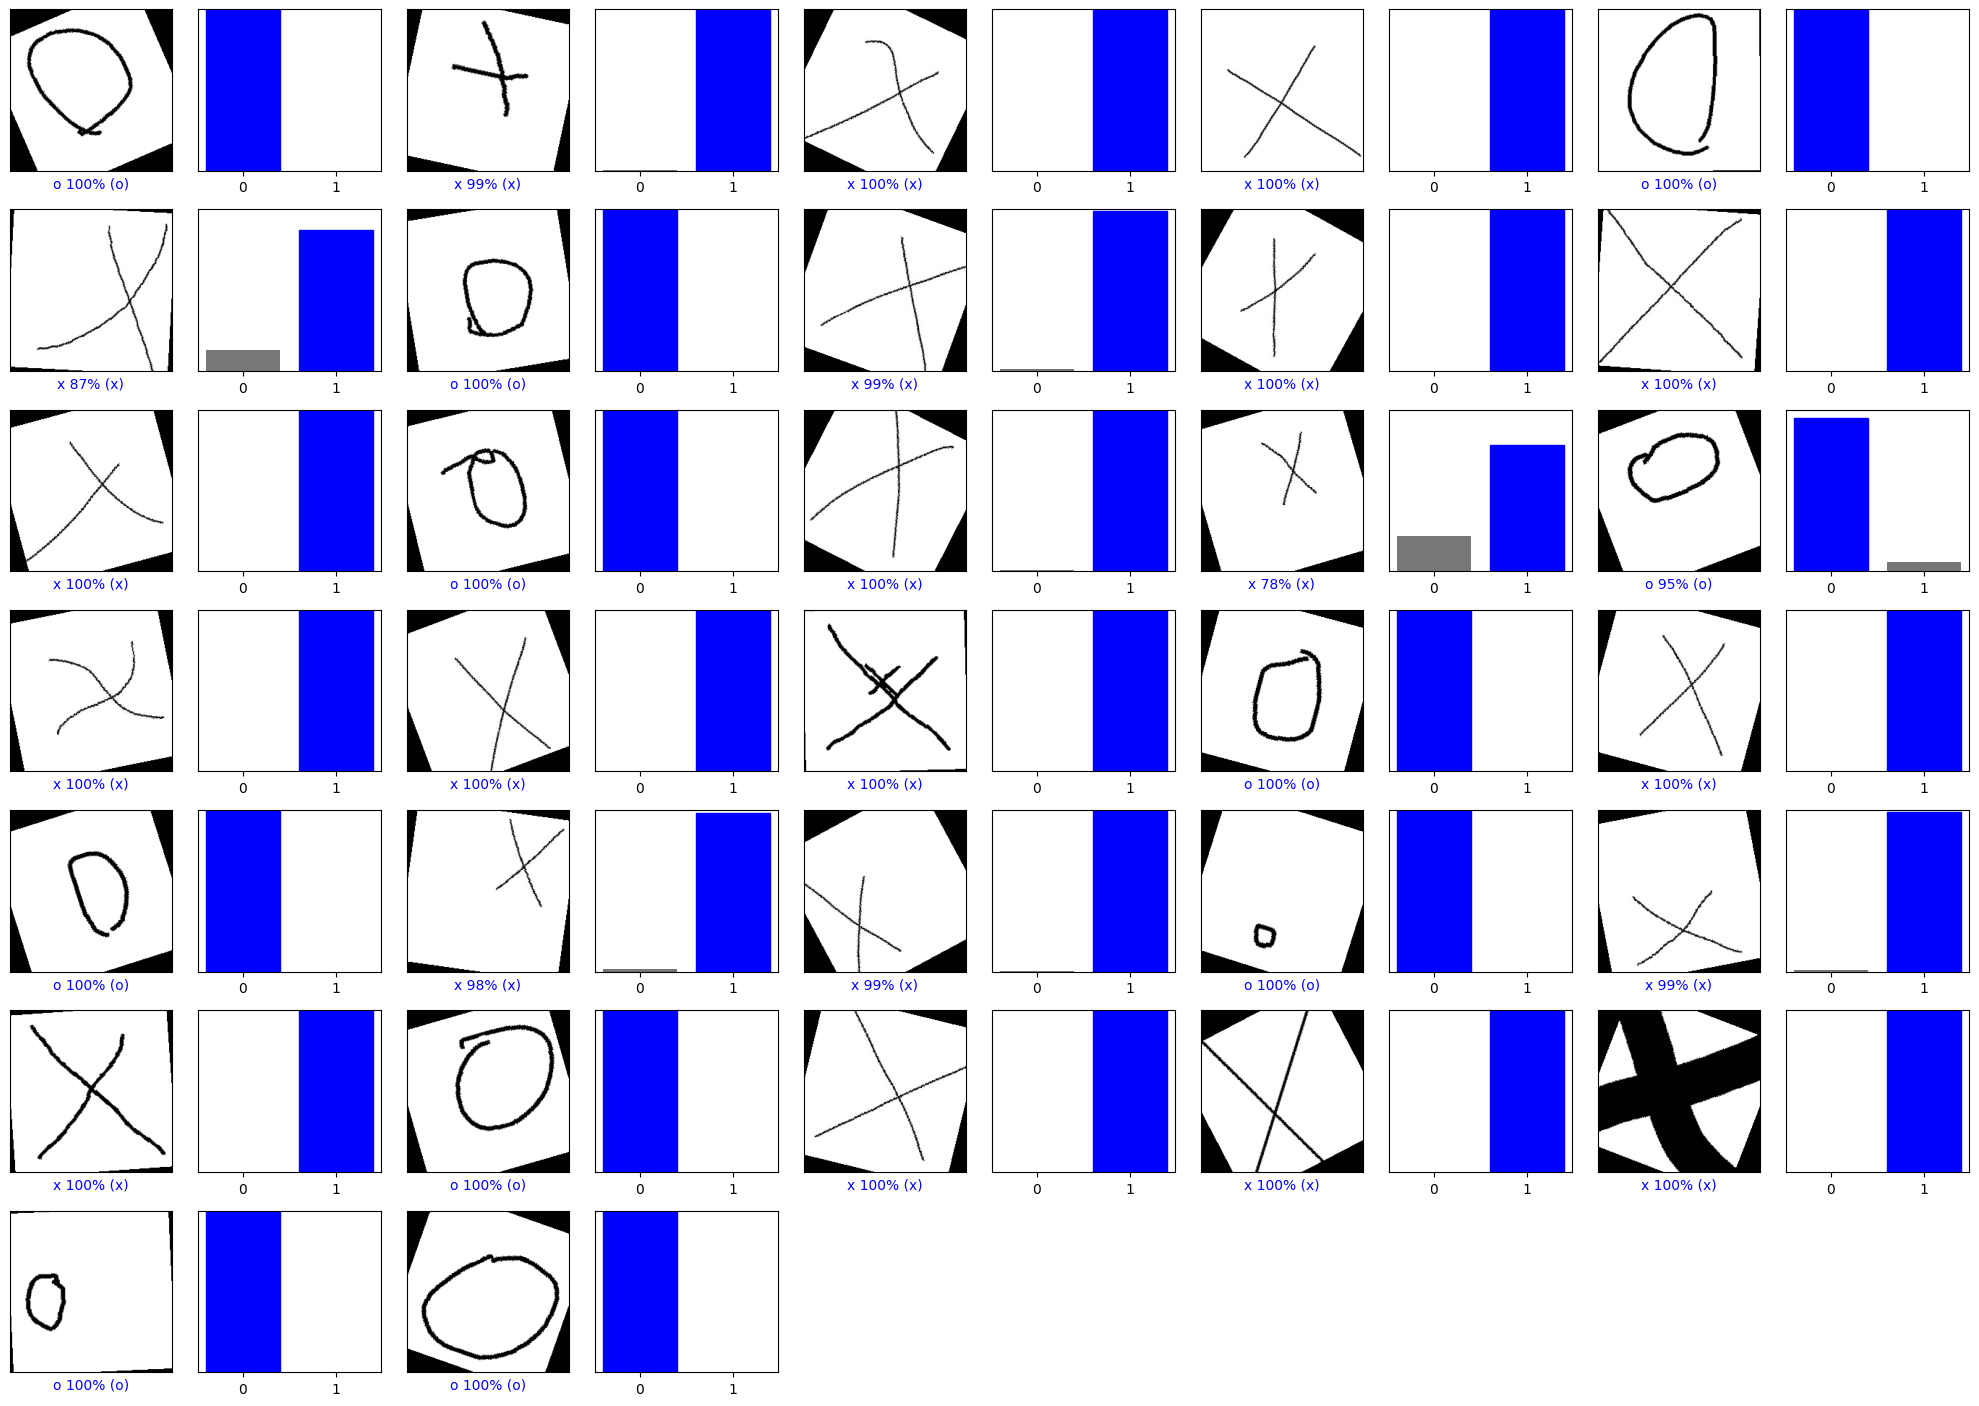

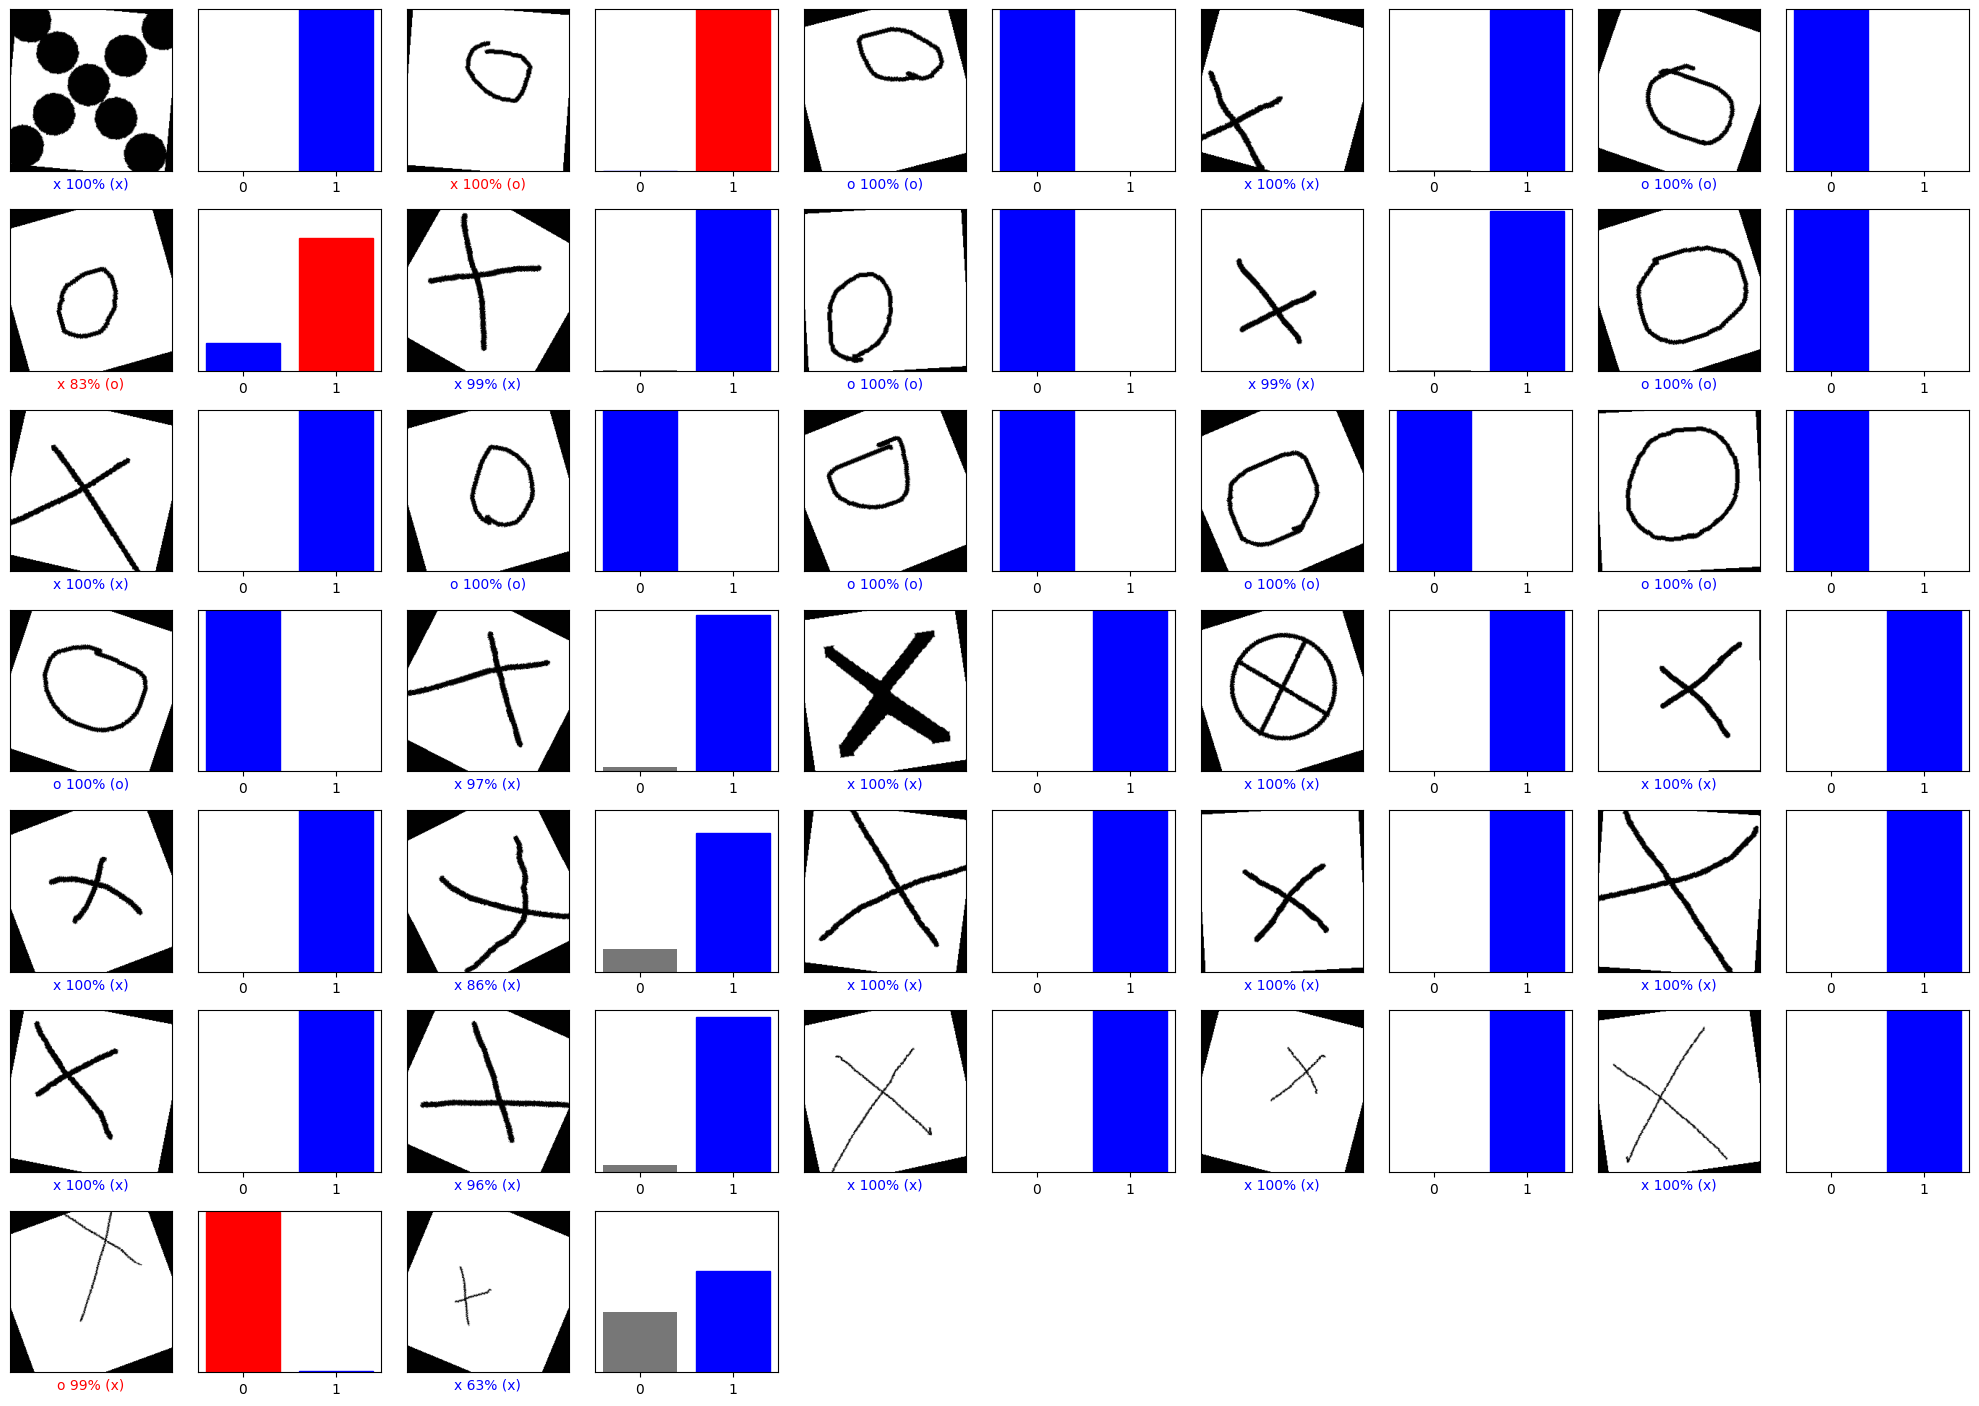

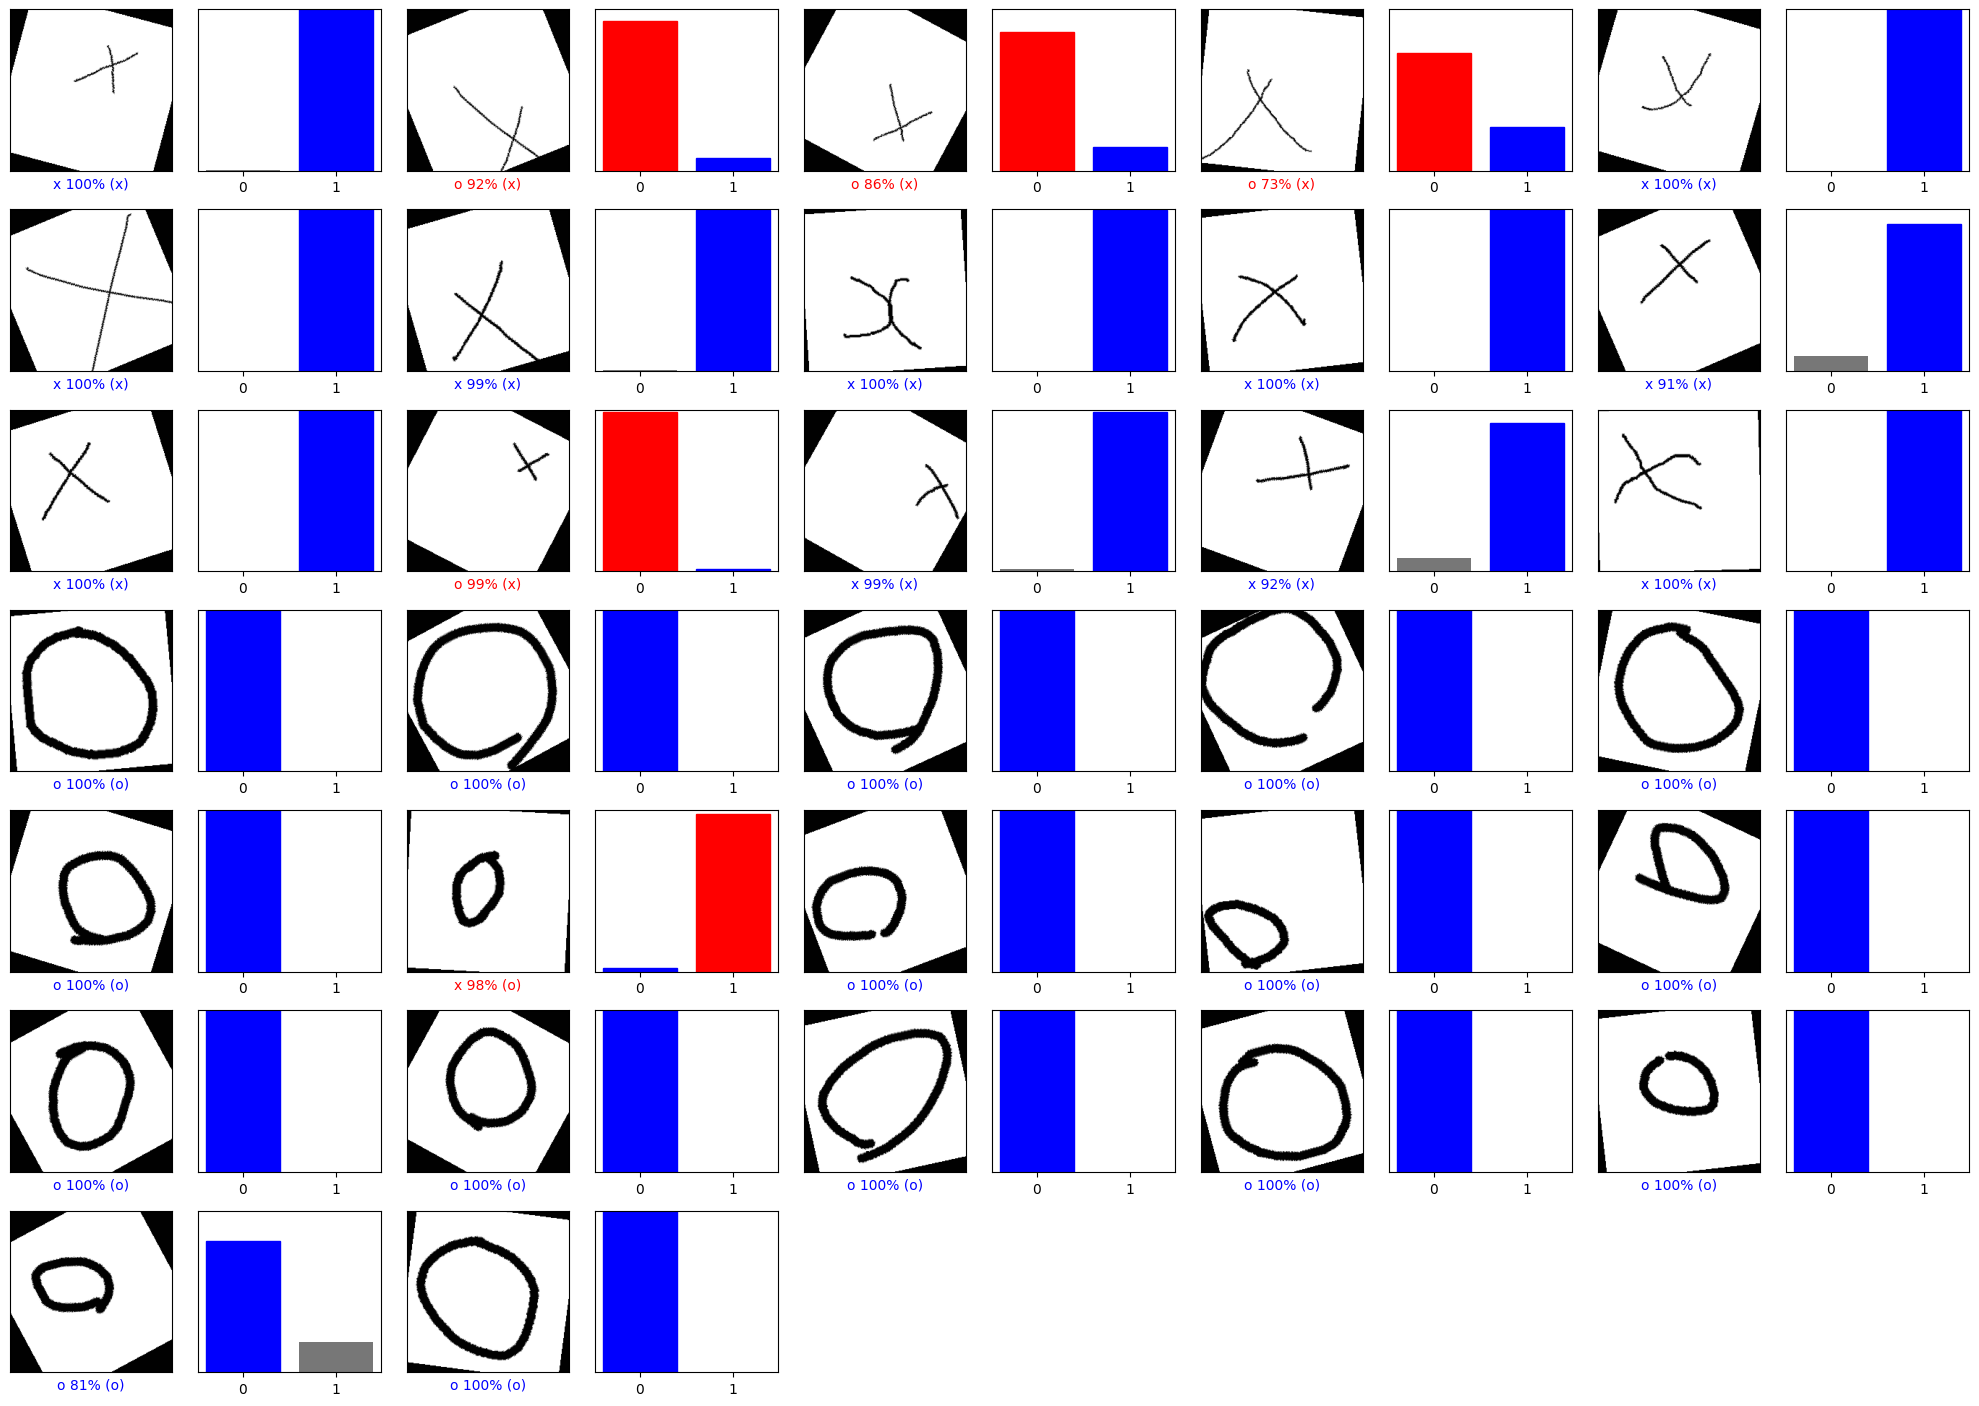

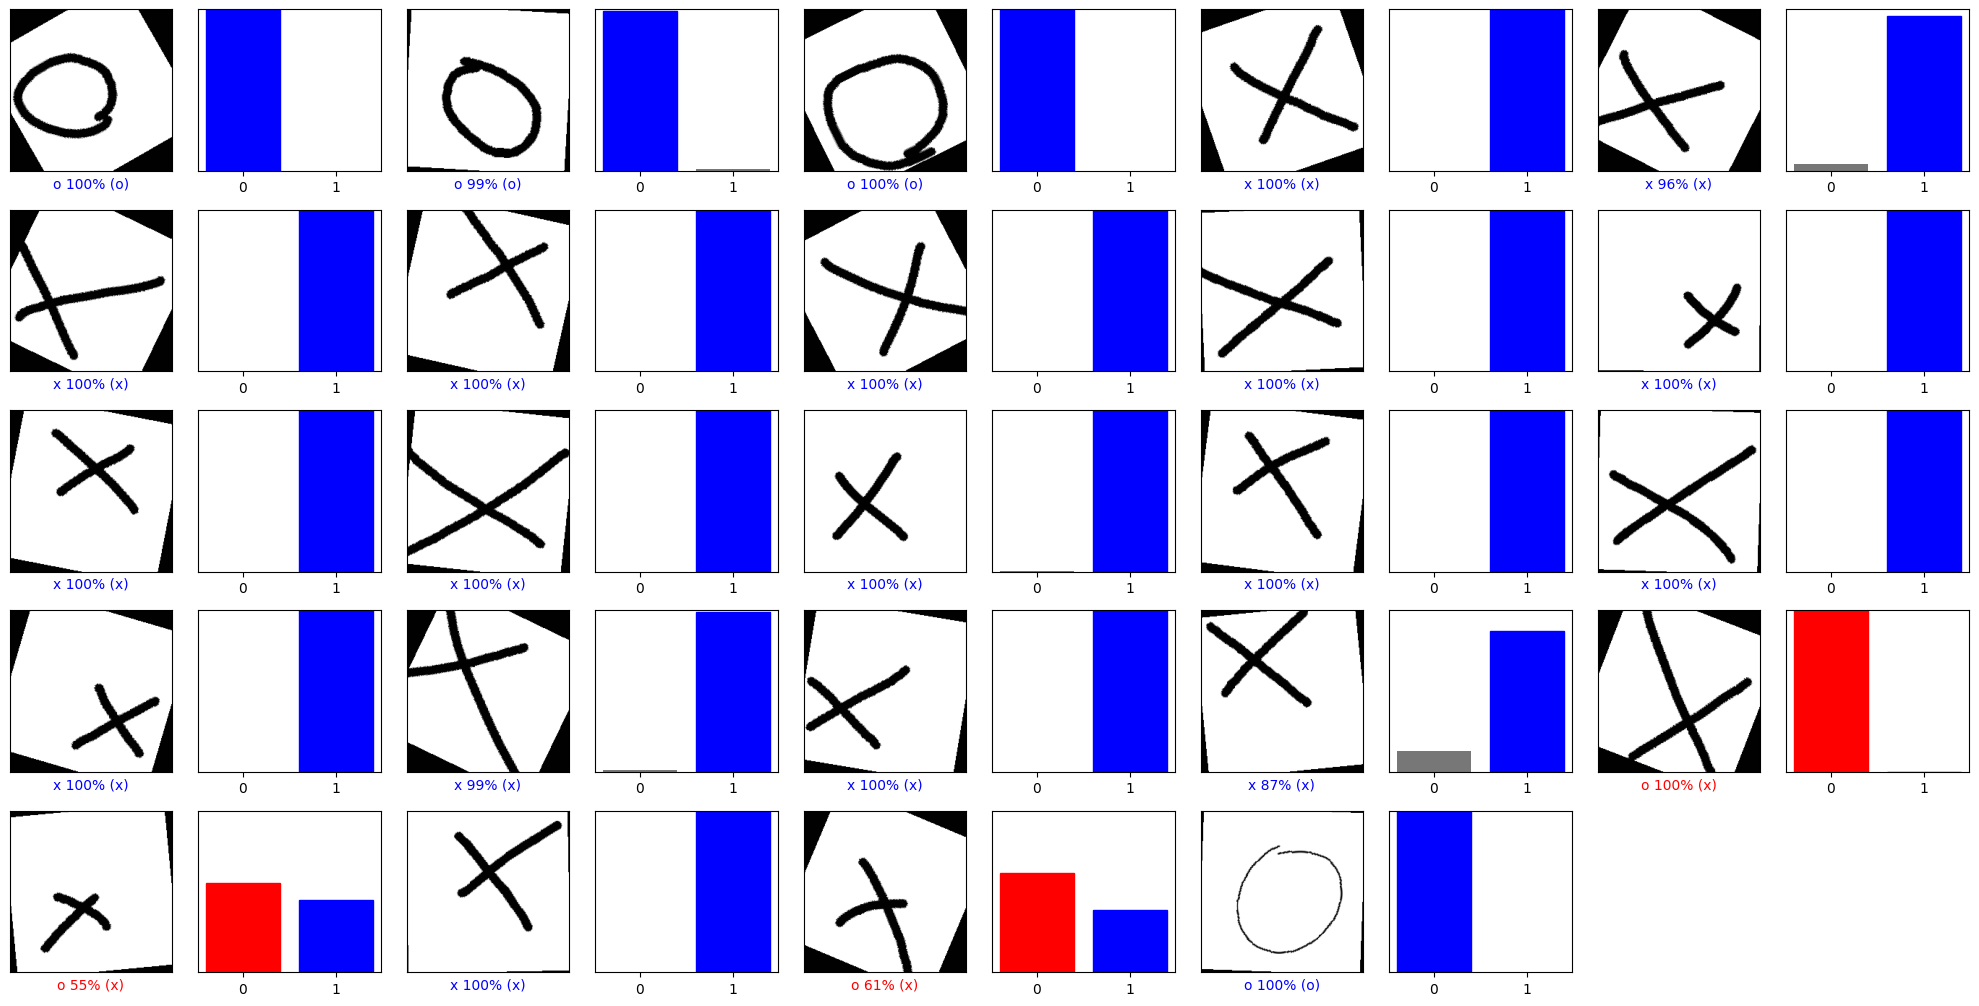

In [ ]:
def plot_image(i, predictions_array, true_labels, img):
  true_label, img = true_labels[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(transforms.ToPILImage()(img.cpu()), cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  label_names=['o','x']

  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(label_names[predicted_label],
                                100*np.max(predictions_array),
                                label_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_labels):
  true_label = true_labels[i]
  plt.grid(False)
  plt.xticks(range(2))
  plt.yticks([])
  thisplot = plt.bar(range(2), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

def visualize_predictions(model, images, labels, device):
    model.eval()
    with torch.no_grad():
        # 전체 이미지를 배치 단위로 나누기 (여기서는 batch_size를 32로 설정)
        batch_size = 32
        num_batches = int(np.ceil(len(images) / batch_size))

        for batch_idx in range(num_batches):
            start_idx = batch_idx * batch_size
            end_idx = min((batch_idx + 1) * batch_size, len(images))
            batch_images = images[start_idx:end_idx].to(device)
            batch_labels = labels[start_idx:end_idx].to(device)

            outputs = model(batch_images)
            predictions = torch.softmax(outputs, dim=1).cpu().numpy()
            batch_labels = batch_labels.cpu().numpy()

            num_images = batch_images.size(0)
            num_cols = 5
            plt.figure(figsize=(2 * 2 * num_cols, 2 * num_images))

            for i in range(num_images):
                plt.subplot(num_images, 2 * num_cols, 2 * i + 1)
                plot_image(i, predictions[i], batch_labels, batch_images)
                plt.subplot(num_images, 2 * num_cols, 2 * i + 2)
                plot_value_array(i, predictions[i], batch_labels)

            plt.tight_layout()
            plt.show()

# 데이터 로더 대신 전체 이미지로 시각화
visualize_predictions(model, images, labels, device)